In [58]:
import nltk
import pandas as pd
import numpy as np
import matplotlib
import random 
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [118]:
# Helper Functions

def plot_class_distribution (data_frame, groupby_feature,class_name, starting_index=0):
    grouped  = data_frame.groupby([class_name]) 
    values=grouped[groupby_feature].agg(np.size)[starting_index:]  
    labels =  values.index.tolist()  
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, values)
    plt.xticks(y_pos, labels)
    plt.xlabel('Product categories')
    plt.ylabel('Number of Products')
    plt.show()


In [59]:
inputFile="../data/labeled/labeled_dataV1.csv"
df = pd.read_csv(inputFile)
#df=df[1:500000]

# our categories and their related words
classes=['unisex', 'men', 'women', 'kid', 'baby']
 

labeled_data=df[df['class']!= '-1'].copy()

#encode the classes to their index 
labeled_data['labels']=labeled_data['class'].apply( classes.index)
print(classes)


['unisex', 'men', 'women', 'kid', 'baby']


### Remove unnecessary columns

In [110]:
#get rid 
#df.drop(labels=['description', 'unisex', 'men', 'women', 'baby', 'kid', 'store_product_brand_domain'], axis=1)
#df.loc[:, ['product_type','full_store_product_url','all_tokens','all_text','all_text_original','primary_price' ]]

In [60]:
# Helper Functions

def plot_class_distribution (data_frame, groupby_feature,class_name, starting_index=0):
    grouped  = data_frame.groupby([class_name]) 
    values=grouped[groupby_feature].agg(np.size)[starting_index:]  
    labels =  values.index.tolist()  
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, values)
    plt.xticks(y_pos, labels)
    plt.xlabel('Product categories')
    plt.ylabel('Number of Products')
    plt.show()


# Bag of Words Counts 

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,2))
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer


list_corpus = labeled_data["all_text"].tolist()
list_labels = labeled_data["labels"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, 
                                                    list_labels, test_size=0.2,
                                                     random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

#size of our features
X_train_counts.shape

(49033, 153035)

## Visualizing the embeddings
Since visualizing data in large dimensions is hard, let's project it down to 2.

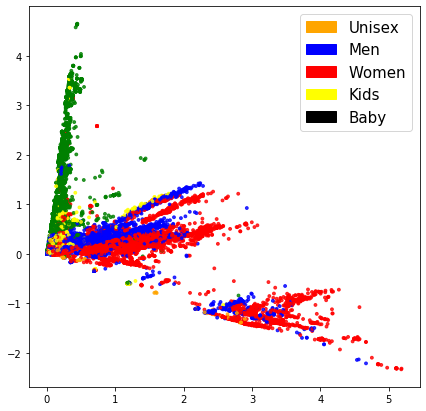

In [117]:


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','red', 'yellow', 'green']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Unisex')
            blue_patch = mpatches.Patch(color='blue', label='Men')
            red_patch = mpatches.Patch(color='red', label='Women')
            yellow_patch = mpatches.Patch(color='yellow', label='Kids')
            green_patch = mpatches.Patch(color='black', label='Baby')
            plt.legend(handles=[orange_patch, blue_patch, red_patch,yellow_patch, green_patch], prop={'size': 15})


fig = plt.figure(figsize=(7, 7))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [63]:
#display(df.head())
#display(labeled_data.head())

print(df.shape)
print(labeled_data.shape)

(500000, 19)
(61292, 20)


## Fitting logistic regression


In [64]:
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

## Evaluation

In [67]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.998, precision = 0.998, recall = 0.998, f1 = 0.998


In [120]:
y_predicted_counts

array([1, 3, 4, ..., 4, 4, 1])

## Let's see how confident is our classifier 

In [65]:
allRecords_probabilty=clf.predict_proba(X_test_counts)

allRecords_max_probabilty = []
for i in range(0, allRecords_probabilty.shape[0]):
    probablities=allRecords_probabilty[i]
    prob_index= np.argmax(probablities)
    prob_max= max(probablities)
    allRecords_max_probabilty.append(prob_max)
    


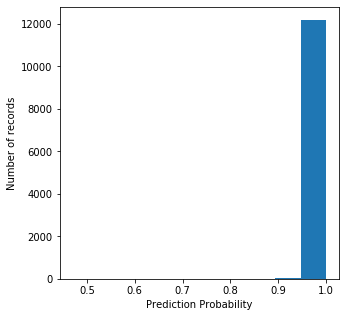

In [66]:


fig = plt.figure(figsize=(5, 5)) 
plt.xlabel('Prediction Probability')
plt.ylabel('Number of records')
plt.hist(allRecords_max_probabilty)
plt.show()

## Inspection
 Let's start by looking at the confusion matrix.

In [113]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=15)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)

    return plt

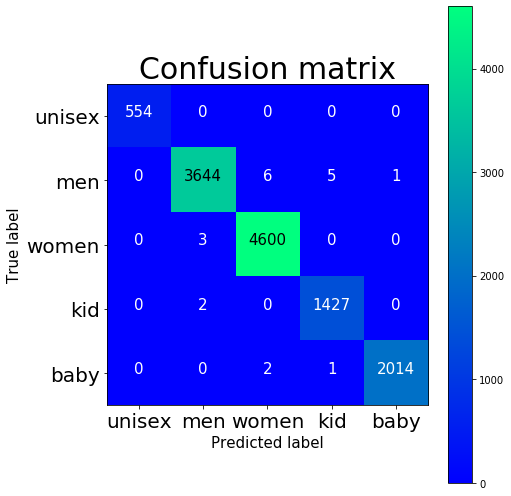

[[ 554    0    0    0    0]
 [   0 3644    6    5    1]
 [   0    3 4600    0    0]
 [   0    2    0 1427    0]
 [   0    0    2    1 2014]]


In [114]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(7, 7))
plot = plot_confusion_matrix(cm, classes=classes, normalize=False, title='Confusion matrix')
plt.show()
print(cm)

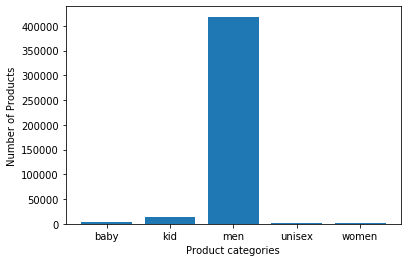

men       418451
kid        14134
baby        4367
unisex       907
women        849
Name: class, dtype: int64


In [121]:
plot_class_distribution (unlabeled_data, 'product_type','class', starting_index=0)
print(unlabeled_data['class'].value_counts())

## Further inspection
Let's look at the features our classifier is using to make decisions.

In [70]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 15)


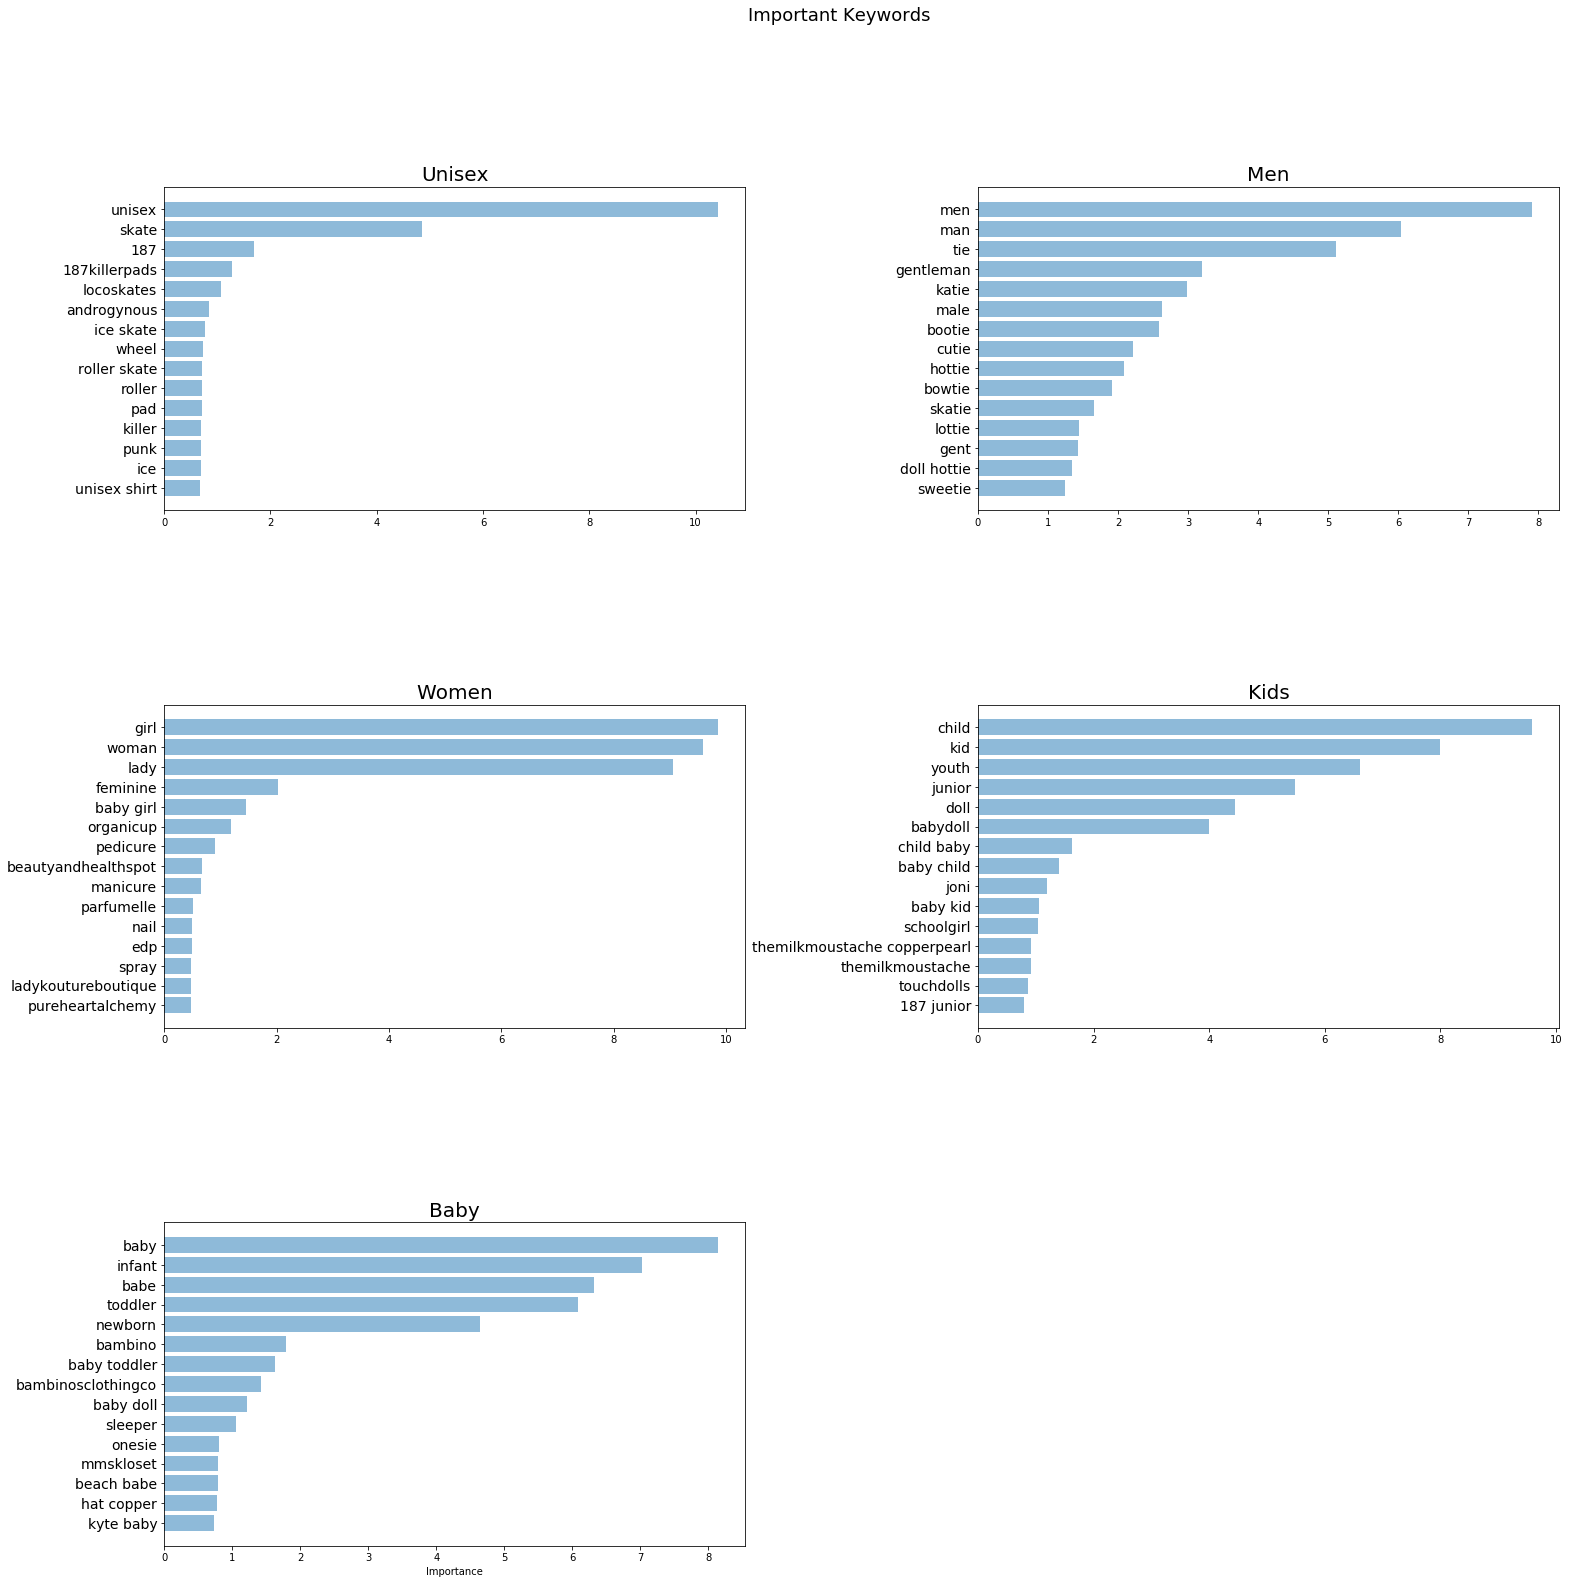

In [71]:


def plot_important_words( top_words, top_scores, label, position):

    y_pos = np.arange(len(top_words))
    plt.subplot(position)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title(label, fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)




top_scores_unisex = [a[0] for a in importance[0]['tops']]
top_words_unisex = [a[1] for a in importance[0]['tops']]

top_scores_men = [a[0] for a in importance[1]['tops']]
top_words_men = [a[1] for a in importance[1]['tops']]

top_scores_women = [a[0] for a in importance[2]['tops']]
top_words_women = [a[1] for a in importance[2]['tops']]

top_scores_kid = [a[0] for a in importance[3]['tops']]
top_words_kid = [a[1] for a in importance[3]['tops']]

top_scores_baby = [a[0] for a in importance[4]['tops']]
top_words_baby = [a[1] for a in importance[4]['tops']]

#plot_important_words(top_scores_unisex, top_words_unisex, top_scores_men, top_words_men, "Most important words")


unisex_pairs = [(a,b) for a,b in zip(top_words_unisex, top_scores_unisex)]
men_pairs = [(a,b) for a,b in zip(top_words_men, top_scores_men)]
unisex_pairs = [(a,b) for a,b in zip(top_words_unisex, top_scores_unisex)]
men_pairs = [(a,b) for a,b in zip(top_words_men, top_scores_men)]

fig = plt.figure(figsize=(25, 25))  
plot_important_words(top_words_unisex, top_scores_unisex, "Unisex", 321)   
plot_important_words(top_words_men, top_scores_men, "Men", 322)
plot_important_words(top_words_women, top_scores_women, "Women", 323)
plot_important_words(top_words_kid, top_scores_kid, "Kids", 324)
plot_important_words(top_words_baby, top_scores_baby, "Baby", 325)

plt.subplots_adjust(wspace=0.4, hspace = 0.6)
plt.suptitle("Important Keywords", fontsize=18)
plt.xlabel('Importance')
plt.show()

In [72]:
#from pivottablejs import pivot_ui
#pivot_ui(labeled_data )

## let's see how our CLF model performs on unseen data
We can use the prediction probability as a performance metric

In [73]:
unlabeled_data= df[df['class'] == '-1'].copy()

In [74]:
list_corpus = unlabeled_data["all_text"].tolist()
#list_labels = unlabeled_data["labels"].tolist()
X_test_counts = count_vectorizer.transform(list_corpus)
y_test_counts = clf.predict(X_test_counts)

# add prediction to the unlabeled_data dataframe
unlabeled_data['labels']=y_test_counts
unlabeled_data['class']=unlabeled_data['labels'].apply( classes.__getitem__)
print(X_test_counts.shape)

(438708, 153035)


In [104]:
allRecords_probabilty=clf.predict_proba(X_test_counts)

allRecords_max_probabilty = []
for i in range(0, allRecords_probabilty.shape[0]):
    probablities=allRecords_probabilty[i]
    prob_index= np.argmax(probablities)
    prob_max= max(probablities)
    allRecords_max_probabilty.append(prob_max)

# add prediction probability to the unlabeled_data dataframe
unlabeled_data['probability']= allRecords_max_probabilty


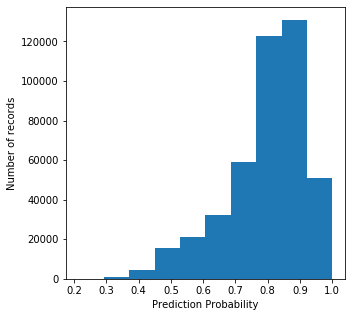

In [101]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5)) 
plt.xlabel('Prediction Probability')
plt.ylabel('Number of records')
plt.hist(allRecords_max_probabilty)
plt.show()

In [77]:
confidence_threshold=0.8
high_confidence=unlabeled_data[unlabeled_data['probability']>= confidence_threshold] 
high_confidence_size=high_confidence.shape[0]
low_confidence_size=unlabeled_data.shape[0]-  high_confidence_size
print( "Number of records predicted with high confidence is {} out of {}".format( high_confidence_size, unlabeled_data.shape[0]))
print( "Number of records predicted with low confidence is {} out of {}".format( low_confidence_size, unlabeled_data.shape[0]))

Number of records predicted with high confidence is 260443 out of 438708
Number of records predicted with low confidence is 178265 out of 438708


## Let's select 40 random records and check their prediction manually

In [106]:
unisex_products=unlabeled_data[unlabeled_data['class']== 'unisex'] 
unisex_products

,Unnamed: 0,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,...,all_tokens,unisex,men,women,baby,kid,class,all_text,labels,probability
8736,8736,"['bag', 'wallet']",['187'],"['187', 'duffle', 'bag', 'war', 'machine', 'bl...","['skateconnection', 'au']",['187killerpads'],[],74.95,https://skateconnection.com.au/products/187duf...,Bags and Wallets 187 187 Duffle Bag War Machin...,...,"['bag', 'wallet', '187', '187', 'duffle', 'bag...",0,0,0,0,0,unisex,bag wallet 187 187 duffle bag war machine blac...,0,0.896867
8737,8737,['wristguards'],"['187', 'killer', 'pad']","['187', 'derby', 'wrist', 'guard']",['daklinic'],['187killerpads'],[],49.95,https://daklinic.com/products/187-derby-wrist,WRISTGUARDS 187 Killer Pads 187 Derby Wrist Gu...,...,"['wristguards', '187', 'killer', 'pad', '187',...",0,0,0,0,0,unisex,wristguards 187 killer pad 187 derby wrist gua...,0,0.996880
8740,8740,"['knee', 'pad']",['187'],"['187', 'knee', 'pad', 'fly', 'knee', 'red', '...","['skatealley', 'co', 'uk']",['187killerpads'],[],39.99,https://skatealley.co.uk/products/187-knee-pad...,Knee Pads 187 187 Knee Pads Fly Knee - Red/Whi...,...,"['knee', 'pad', '187', '187', 'knee', 'pad', '...",0,0,0,0,0,unisex,knee pad 187 187 knee pad fly knee red white b...,0,0.998578
8741,8741,"['protective', 'gear']","['187', 'killer', 'pad']","['187', 'elbow', 'pad', 'pro']","['shinertown', 'au']",['187killerpads'],[],100.0,https://shinertown.com.au/products/187-pro-elb...,Protective Gear 187 Killer Pads 187 Elbow Pads...,...,"['protective', 'gear', '187', 'killer', 'pad',...",0,0,0,0,0,unisex,protective gear 187 killer pad 187 elbow pad p...,0,0.998099
8742,8742,"['elbow', 'pad']",['187'],"['187', 'killer', 'pad', 'pro', 'elbow', 'grey']","['mommatruckerskates', 'co', 'uk']",['187killerpads'],[],44.99,https://mommatruckerskates.co.uk/products/187-...,Elbow Pads 187 187 Killer Pads - Pro Elbow Gre...,...,"['elbow', 'pad', '187', '187', 'killer', 'pad'...",0,0,0,0,0,unisex,elbow pad 187 187 killer pad pro elbow grey mo...,0,0.999802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479952,479952,['scooter'],"['chilli', 'pro']","['chilli', 'pro', 'turbo', 'black', 'black', '...",['locoskates'],"['chilli', 'proscooter']",[],16.67,https://locoskates.com/products/chilli-pro-tur...,Scooter Chilli Pro Chilli Pro Turbo Black / Bl...,...,"['scooter', 'chilli', 'pro', 'chilli', 'pro', ...",0,0,0,0,0,unisex,scooter chilli pro chilli pro turbo black blac...,0,0.752198
486797,486797,['hoodie'],['juniper'],"['mountain', 'logo', 'hoodie']","['juniperclothing', 'ca']","['juniperclothing', 'ca']",[],29.99,https://juniperclothing.ca/products/bold-mount...,Hoodie Juniper Mountain Logo Hoodie juniperclo...,...,"['hoodie', 'juniper', 'mountain', 'logo', 'hoo...",0,0,0,0,0,unisex,hoodie juniper mountain logo hoodie juniperclo...,0,0.484916
486809,486809,['tshirt'],['juniper'],"['come', 'go']","['juniperclothing', 'ca']","['juniperclothing', 'ca']",[],31.99,https://juniperclothing.ca/products/come-on-we...,tshirt Juniper Come on we goes juniperclothing...,...,"['tshirt', 'juniper', 'come', 'go', 'junipercl...",0,0,0,0,0,unisex,tshirt juniper come go juniperclothing ca juni...,0,0.296140
486820,486820,['hoodie'],"['juniper', 'clothing']","['deadly', 'hoodie']","['juniperclothing', 'ca']","['juniperclothing', 'ca']",[],49.99,https://juniperclothing.ca/products/deadly-hoodie,Hoodie Juniper Clothing Deadly Hoodie juniperc...,...,"['hoodie', 'juniper', 'clothing', 'deadly', 'h...",0,0,0,0,0,unisex,hoodie juniper clothing deadly hoodie juniperc...,0,0.344465


In [103]:

random_records=random.sample(unlabeled_data.index.to_list(), k=20) 
test=unlabeled_data.loc[random_records, ['class','labels','product_type','full_store_product_url' ,'all_text_original']]
display(test)
test.to_csv("../data/validate/test_random_unseen_data_LogisticReg.csv", index=True)

,class,labels,product_type,full_store_product_url,all_text_original
301021,men,1,['jogger'],https://khazanay.pk/products/brooks-gts-s-49488,Joggers Brooks Brooks GTS khazanay.pk brooksru...
369577,men,1,['jacket'],https://brotherswestand.com/products/yarmouth-...,Jackets Yarmouth Oilskins Yarmouth Oilskins Dr...
173680,men,1,['jumper'],https://heysara.com/products/sass-sunday-morni...,Jumper SASS Sass Sunday Morning Jumper in Grey...
21174,men,1,['wheel'],https://hardparkpro.com/products/vorsteiner-v-...,Wheels Vorsteiner Vorsteiner V-FF 112 Wheel (1...
26281,men,1,['flake'],https://lemminglacquer.com/products/cosmic-dip...,Flakes Lemming Lacquer Cosmic Dipshits lemming...
320191,men,1,"['top', 'bikini']",https://zueswimwear.com/products/top-balconett...,Top Bikini Zue Swimwear TOP Balconette Embera ...
45215,men,1,['cooky'],https://frankandsal.com/products/mulino-bianco...,Cookies Frank and Sal Mulino Bianco Settembri...
30902,men,1,['mug'],https://felizland.com/products/cup-of-love-con...,Mug Felizland Cup Of Love - Heart Mug felizlan...
140086,men,1,[],https://ellany.com/products/ellany-windbreaker...,nan Ellany Equestrian Ellany Windbreaker - Nav...
354011,men,1,[],https://bapsaccessories.com/products/seven,nan B.A.P.S. Accessories Seven bapsaccessories...


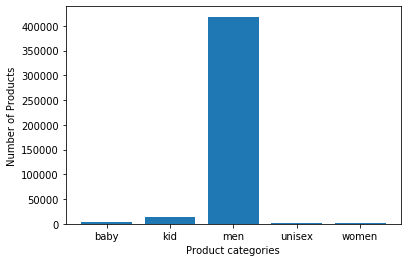

men       418451
kid        14134
baby        4367
unisex       907
women        849
Name: class, dtype: int64


In [88]:
plot_class_distribution (unlabeled_data, 'product_type','class', starting_index=0)
print(unlabeled_data['class'].value_counts())

In [122]:
df[df['class']==-1]

,Unnamed: 0,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,vendor_name_original,all_tokens,unisex,men,women,baby,kid,class,all_text
